In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_scores, plot_predict_result
%matplotlib notebook

In [48]:
df = pd.read_csv('../data/ready/dataset_houses.csv')
df = df[df['precio']<1000000]

features = df.drop(columns='precio')
price = df['precio']

# Usefull methods to explore features
- df.description()
- df.shape
- df.count()
- df.sum()
- df.mean()
- df.std()
- df.corr()

- `df['feature'].unique()`
- `df.nunique()`
- `df['feature'].isna()`



# Modeling

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
# Train/test
from sklearn.model_selection import train_test_split
# Descomposition
from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from sklearn.model_selection import cross_val_score

 

## Split train and test dataset

In [50]:
X_train, X_test = train_test_split(features, test_size=0.2, random_state=0)
y_train, y_test = train_test_split(price, test_size=0.2, random_state=0)

## Check train and test distributions

<IPython.core.display.Javascript object>


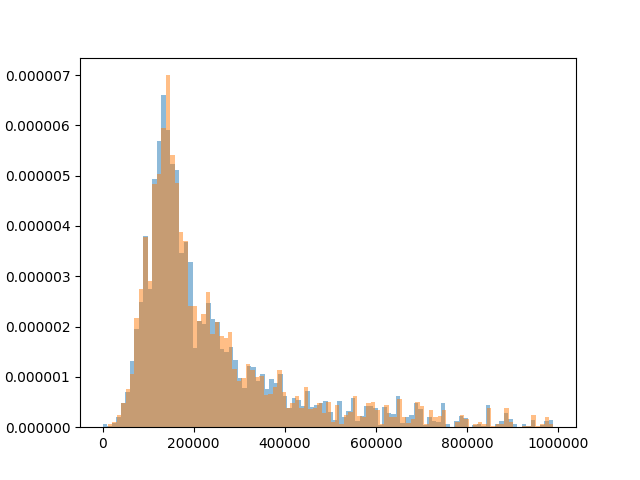

In [51]:
plt.figure()
plt.hist(y_train, bins=100, density=True, alpha=0.5);
plt.hist(y_test, bins=100, density=True, alpha=0.5);

## Scale dataset

In [52]:
# scaler =  RobustScaler(quantile_range=(25, 75))
scaler_target = QuantileTransformer(output_distribution='normal', ) 
# scaler = PowerTransformer(method='box-cox')  # Non Linear | Strictly positive data
# scaler = PowerTransformer(method='yeo-johnson')  # Non Linear 
scaler_feature = MinMaxScaler()


In [53]:
scale_train = scaler_feature.fit_transform(X_train)
# scale_train = scaler_feature.transform(X_train)
scale_test = scaler_feature.transform(X_test)

scale_train_price = scaler_target.fit_transform(y_train.to_numpy()[:, None])
scale_test_price = scaler_target.transform(y_test.to_numpy()[:, None])

## PCA analysis

In [54]:
pca = PCA(n_components=.98, )
pca.fit(scale_train)
arr_train = pca.transform(scale_train)
arr_test = pca.transform(scale_test)

In [55]:
pca.explained_variance_ratio_

array([0.16931876, 0.11887327, 0.08923624, 0.0823609 , 0.06028471,
       0.0511455 , 0.04575569, 0.03981486, 0.03205461, 0.02772286,
       0.02554175, 0.02389725, 0.02314492, 0.02093171, 0.01742225,
       0.01586492, 0.01573012, 0.01445018, 0.01335048, 0.01207   ,
       0.01143276, 0.01113541, 0.01036122, 0.01007787, 0.00912704,
       0.00845178, 0.00807326, 0.00719249, 0.00547484])

<IPython.core.display.Javascript object>


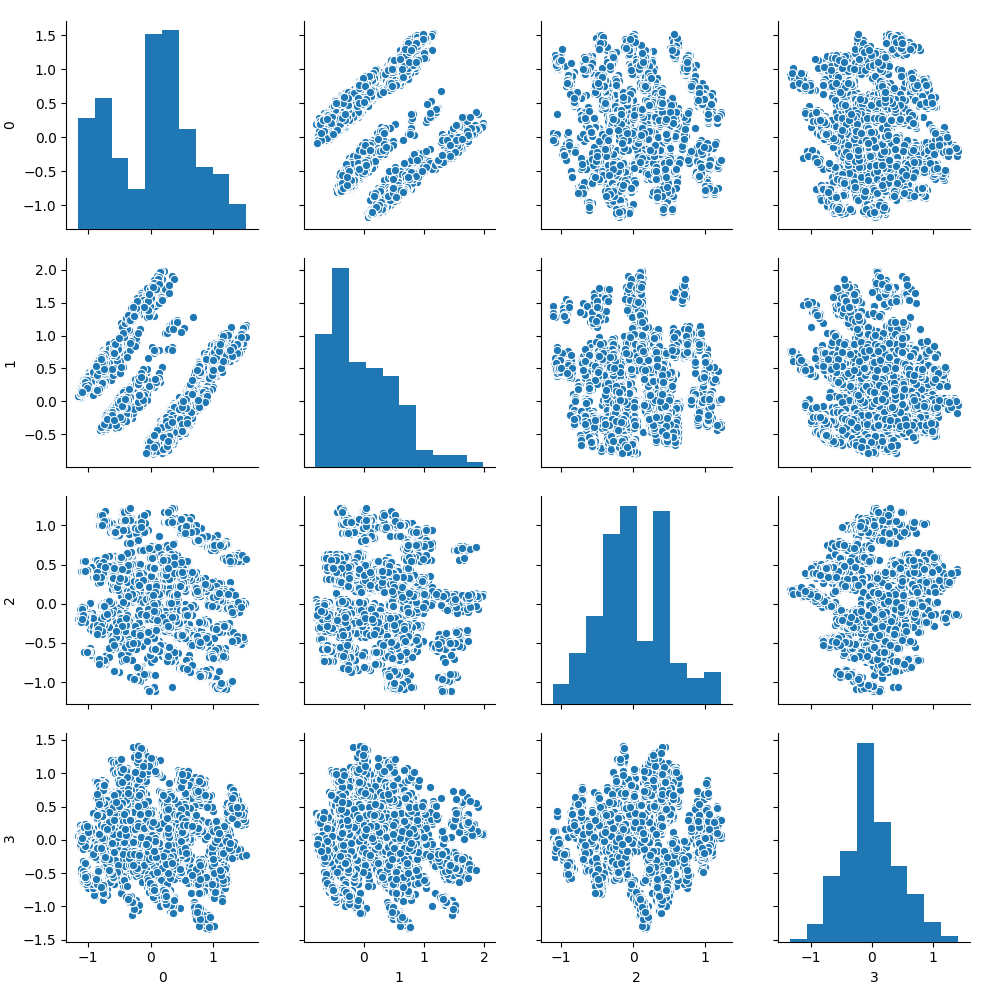

In [56]:
sns.pairplot(pd.DataFrame(arr_train[:, 0:4]))

In [57]:
X_train.columns

Index(['banos', 'banos_extra', 'dormitorios', 'dormitorios_extra', 'garajes',
       'garajes_extra', 'gastos_comunes', 'm2_de_la_terraza', 'm2_edificados',
       'penthouse', 'plantas', 'plantas_extra', 'vivienda_social',
       'cerca_rambla', 'm2_index', 'estado', 'parrilero', 'ZN__aguada',
       'ZN__buceo', 'ZN__carrasco', 'ZN__centro', 'ZN__ciudad vieja',
       'ZN__cordon', 'ZN__desconocido', 'ZN__la blanqueada', 'ZN__malvin',
       'ZN__otros', 'ZN__parque batlle', 'ZN__parque rodo', 'ZN__pocitos',
       'ZN__pocitos nuevo', 'ZN__prado', 'ZN__punta carretas',
       'ZN__tres cruces', 'DISP__al frente', 'DISP__contrafrente',
       'DISP__interior', 'DISP__lateral', 'DISP__otro'],
      dtype='object')

<IPython.core.display.Javascript object>


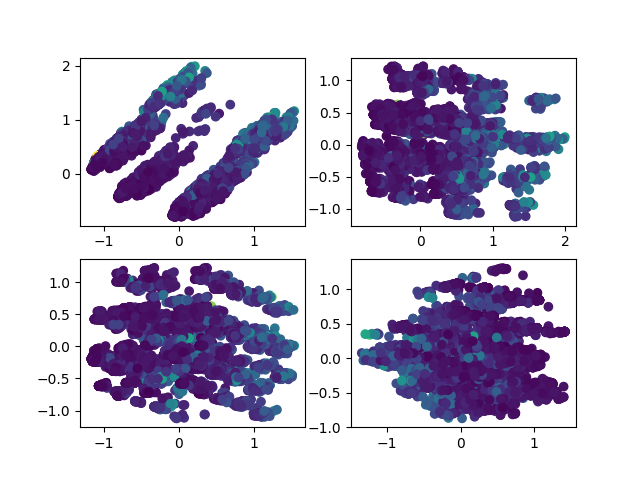

In [58]:
# color = features.loc[features.index, 'zona'].astype('category').cat.codes
color = X_train.iloc[:, 8]
f, ax = plt.subplots(2,2)
ax[0, 0].scatter(arr_train[:,0], arr_train[:,1], c=color)
ax[0, 1].scatter(arr_train[:,1], arr_train[:,2], c=color)
ax[1, 0].scatter(arr_train[:,0], arr_train[:,2], c=color)
ax[1, 1].scatter(arr_train[:,3], arr_train[:,5], c=color)

# Choosing a model

## Linear Model

In [59]:
model = LinearRegression(fit_intercept=True)
model.fit(arr_train, y_train)
#model.coef_, model.intercept_, model.rank_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
predict_price = model.predict(arr_test)
get_scores(y_test, predict_price)


'MSE=10174509825.97, MAE=64879.65, MEAE=39025.12, $R^2$=0.68'

<IPython.core.display.Javascript object>


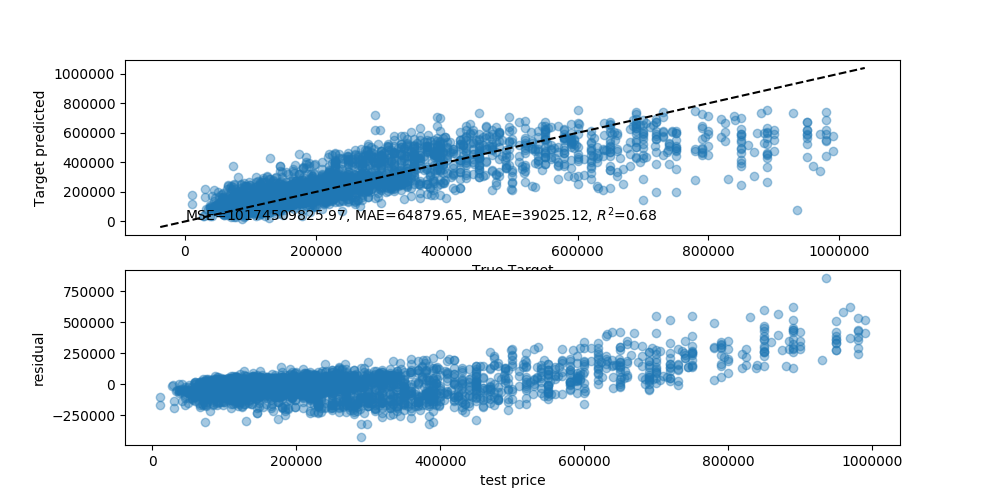

In [61]:
f, ax = plot_predict_result(y_test, predict_price)


## Transformed Target Regressor

In [62]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

<IPython.core.display.Javascript object>


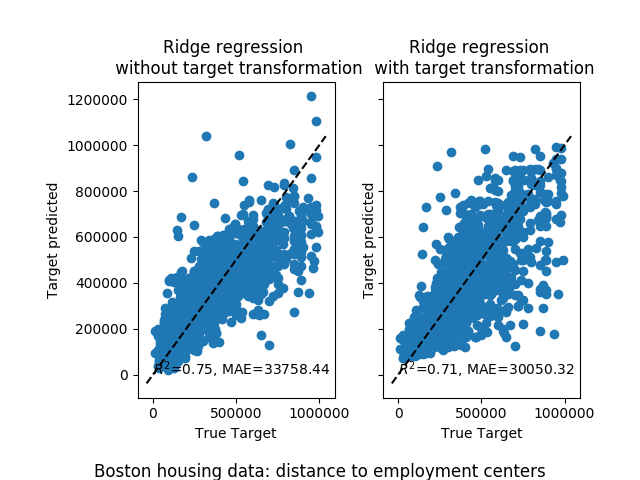

<IPython.core.display.Javascript object>


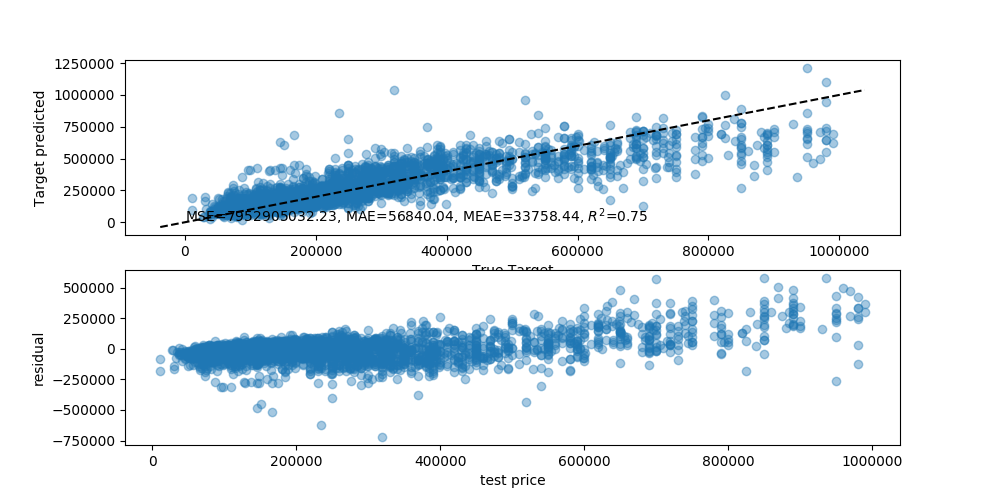

<IPython.core.display.Javascript object>


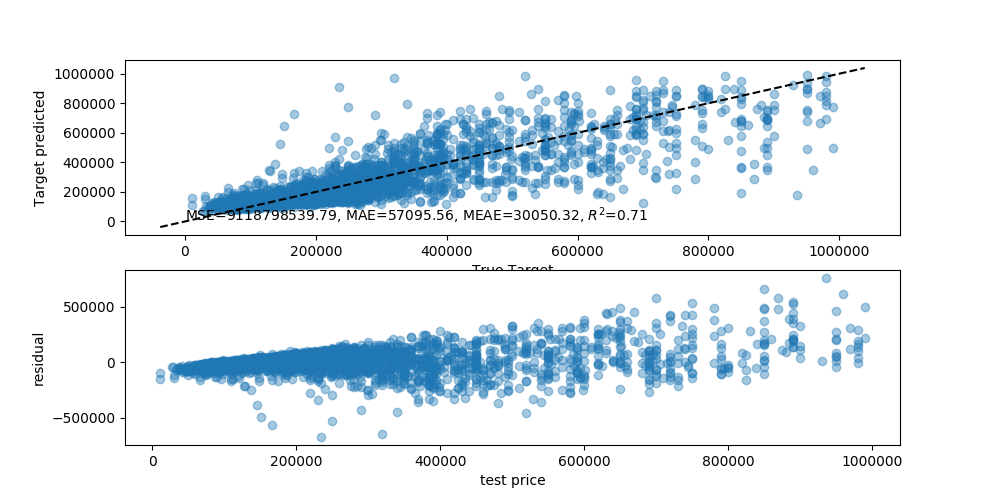

(<Figure size 1000x500 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe049d253c8>,
       dtype=object))

In [63]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot(ax0.get_xbound(), ax0.get_xbound(), '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$={:.2f}, MAE={:.2f}'.format(r2_score(y_test, y_pred),
                                                  median_absolute_error(y_test, y_pred)))

plot_predict_result(y_test, y_pred)

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot(ax1.get_xbound(), ax1.get_xbound(), '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 9, r'$R^2$={:.2f}, MAE={:.2f}'.format(r2_score(y_test, y_pred),
                                                  median_absolute_error(y_test, y_pred)))
# ax1.set_xlim([0, 10])
# ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()
plot_predict_result(y_test, y_pred)


# Regression Tree

<IPython.core.display.Javascript object>


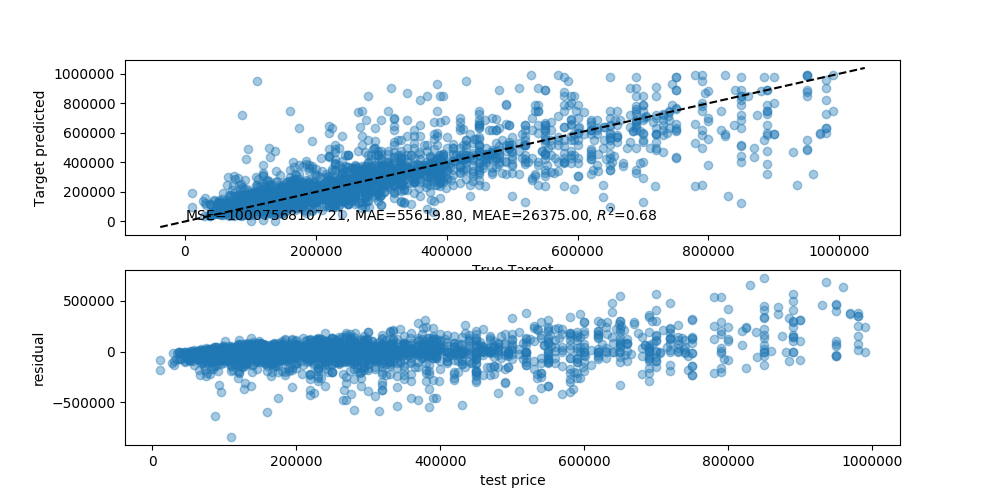

(<Figure size 1000x500 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe04a105c88>,
       dtype=object))

In [64]:
cls_tree = DecisionTreeRegressor()
cls_tree.fit(X_train, y_train)


predic_price_tree = cls_tree.predict(X_test)
get_scores(predic_price_tree, y_test)



scores_accuracy = cross_val_score(cls_tree, features, price, cv=10)
# scores_balanced = cross_val_score(cls_tree, features, price, cv=10, scoring="balanced_accuracy")

scores_accuracy, scores_accuracy.mean()

plot_predict_result(y_test, predic_price_tree)

<IPython.core.display.Javascript object>


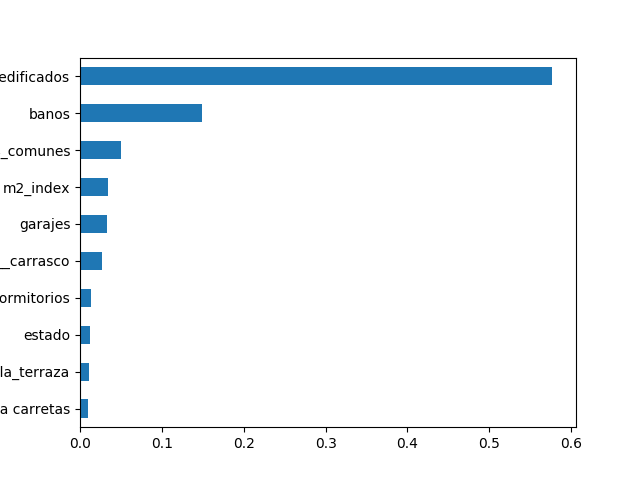

In [65]:
f, ax = plt.subplots()
(pd
 .Series(cls_tree.feature_importances_, index=X_test.columns)
 .sort_values()[-10:]
 .plot(ax=ax, kind='barh')
)

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

<IPython.core.display.Javascript object>


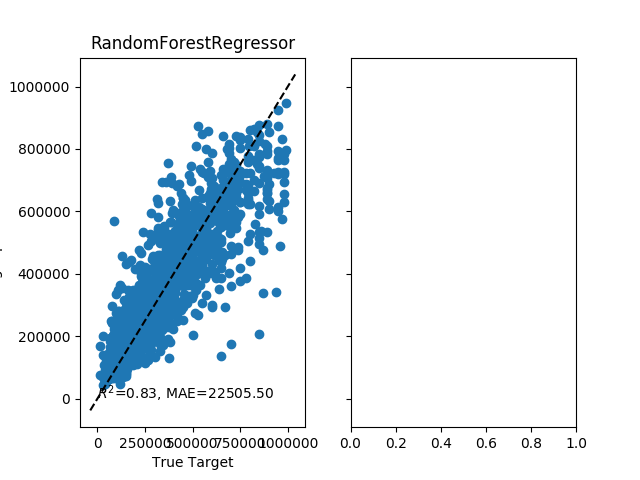

Text(1, 9, '$R^2$=0.83, MAE=22505.50')

In [67]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

rfr = RandomForestRegressor(n_estimators=100,)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot(ax0.get_xbound(), ax0.get_xbound(), '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('RandomForestRegressor')
ax0.text(1, 9, r'$R^2$={:.2f}, MAE={:.2f}'.format(r2_score(y_test, y_pred),
                                                  median_absolute_error(y_test, y_pred)))

<IPython.core.display.Javascript object>


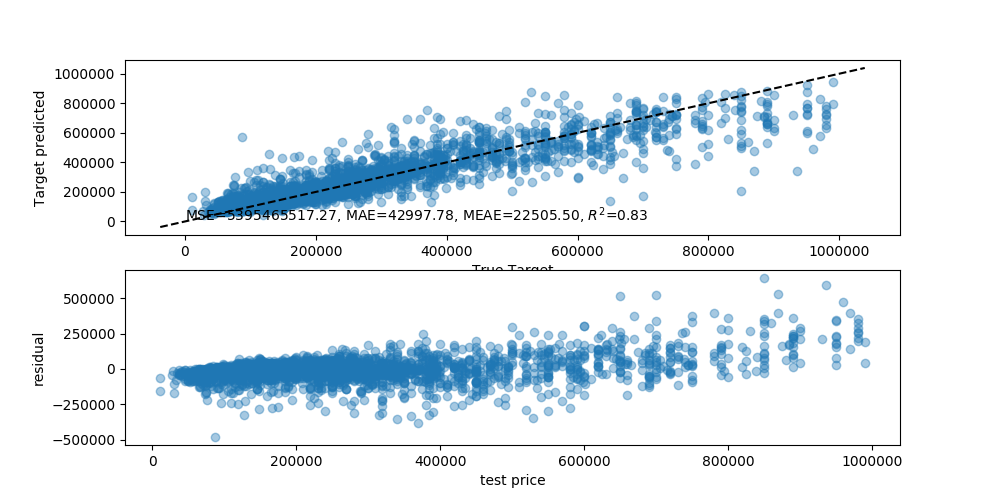

(<Figure size 1000x500 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe04a126898>,
       dtype=object))

In [68]:
plot_predict_result(y_test, y_pred)


In [69]:
pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

m2_edificados         0.571545
banos                 0.113923
gastos_comunes        0.053627
banos_extra           0.038217
garajes               0.035328
m2_index              0.034752
ZN__carrasco          0.026758
dormitorios           0.014382
estado                0.013827
m2_de_la_terraza      0.011718
ZN__pocitos           0.010388
ZN__punta carretas    0.010187
ZN__otros             0.009458
parrilero             0.007331
plantas               0.006192
ZN__centro            0.005438
cerca_rambla          0.004535
DISP__otro            0.003690
DISP__al frente       0.003308
ZN__malvin            0.003189
ZN__cordon            0.002693
ZN__prado             0.002470
ZN__pocitos nuevo     0.002224
garajes_extra         0.001867
dormitorios_extra     0.001849
plantas_extra         0.001450
ZN__la blanqueada     0.001392
ZN__buceo             0.001325
ZN__parque batlle     0.001012
vivienda_social       0.000960
penthouse             0.000818
ZN__aguada            0.000795
DISP__co